In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/data/

Mounted at /content/drive
/content/drive/My Drive/cs231n/final_project/data


Directly using the WikiArt Dataset proves to be very slow, as each image has varing sizes and are large. We concatenate two resized datasets from Wikiart for faster training & testing.
The code below will be only run once to download, preprocess, and dump the pre-processed dataset to drive.

In [ ]:
# instantiate pytorch and huggingface
# Only needs to be called once, will just load from google drive in the future
! pip install transformers
! pip install datasets
from datasets import load_dataset
dataset = load_dataset("davanstrien/wikiart-resized")['train']
dataset.save_to_disk('wikiart')

In [ ]:
! pip install datasets
from datasets import load_from_disk
dataset = load_from_disk('wikiart')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# The resized dataset have some missing images. Filter them out
filtered_dataset = dataset.filter(lambda example: example['image'] is not None)
filtered_dataset.save_to_disk('filtered_wikiart')

Filter:   0%|          | 0/81444 [00:00<?, ? examples/s]

In [ ]:
sample_dataset = load_dataset("davanstrien/wikiart-resized-sample")['train'].filter(lambda example: example['image'] is not None)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from datasets import concatenate_datasets
combined_dataset = concatenate_datasets([filtered_dataset, sample_dataset])
combined_dataset.save_to_disk('preprocessed_wikiart')

Saving the dataset (0/8 shards):   0%|          | 0/62403 [00:00<?, ? examples/s]

For simplicity & reproducable results, I've gather all codes above in a file, so that on other notebooks just running the cell below will be sufficient:

In [ ]:
! pip install transformers
! pip install datasets
! python3 preprocess_data.py

Now we have a proprocessed dataset, so that everytime we inititae, we just need to load from disk by running the cell below:

In [ ]:
! pip install datasets
from datasets import load_from_disk
dataset = load_from_disk('preprocessed_wikiart')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [ ]:
'''
from PIL import Image
import numpy as np
from torchvision.transforms import functional as F

def resize_image(example):
    # Convert numpy array image to a PIL image
    image = torch.tensor(np.array(example['image'], dtype='int32'))

    # Center crop the image to 224*224
    image = F.center_crop(image, output_size=(224, 224))
    image = image.permute(2, 0, 1)

    # Convert the image back to numpy array
    example['image'] = image

    return example

# Assuming `dataset` is your HuggingFace dataset
new_dataset = dataset.select([0, 1, 2, 3, 4])
resized_dataset = new_dataset.map(resize_image)
'''

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [ ]:
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
new_split = train_dataset.train_test_split(test_size=0.2)
train_dataset = new_split['train']
val_dataset = new_split['test']
test_dataset = split['test']

In [ ]:
# Let's assume your input data is stored in the 'input' column and the labels are in the 'label' column
train_dataset.set_format(type='torch', columns=['image', 'artist', 'genre', 'style'])
test_dataset.set_format(type='torch', columns=['image', 'artist', 'genre', 'style'])
val_dataset.set_format(type='torch', columns=['image', 'artist', 'genre', 'style'])

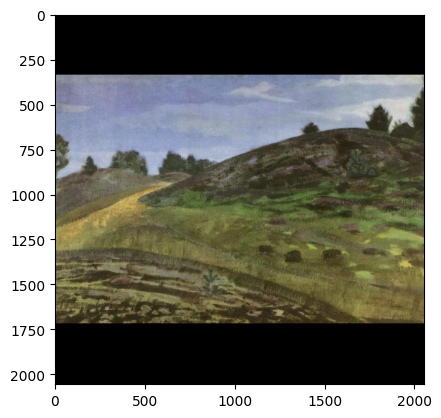

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.show()

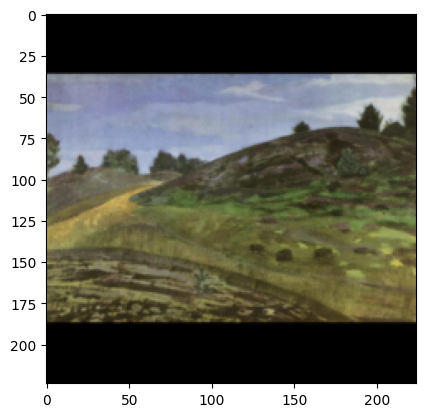

In [ ]:
down_scale_resize = transforms.Resize((224, 224), antialias=True)
img_down = down_scale_resize(img)
plt.imshow(img_down.permute(1, 2, 0))
plt.show()

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
transform = transforms.CenterCrop((224, 224))

class Resized_Dataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __getitem__(self, index):
        # Get image and label from the original dataset
        item = self.original_dataset[index]

        # Apply the transformation
        item['image'] = transform(item['image'].permute(2, 0, 1))

        return item

    def __len__(self):
        return len(self.original_dataset)

In [ ]:
train_dataset_resized_scaled = Resized_Dataset(train_dataset)
test_dataset_resized_scaled = Resized_Dataset(test_dataset)
val_dataset_resized_scaled = Resized_Dataset(val_dataset)

In [ ]:
from torchvision.models import resnet50

class ResNet50(nn.Module):
    def __init__(self, num_classes1=129, num_classes2=11, num_classes3=27):
        super(ResNet50, self).__init__()

        # load the pretrained ResNet50 model from torchvision
        base_model = resnet50(weights='DEFAULT')

        # remove the last FC layer
        base_modules = list(base_model.children())[:-1]
        self.base_model = nn.Sequential(*base_modules)

        # define the new FC layer (task 1)
        self.fc1 = nn.Linear(in_features=2048, out_features=num_classes1)

        # define the new FC layer (task 2)
        self.fc2 = nn.Linear(in_features=2048, out_features=num_classes2)

        # define the new FC layer (task 3)
        self.fc3 = nn.Linear(in_features=2048, out_features=num_classes3)

    def forward(self, x):
        features = self.base_model(x)

        # flatten the output
        features = features.view(features.size(0), -1)

        output1 = self.fc1(features)
        output2 = self.fc2(features)
        output3 = self.fc3(features)

        return output1, output2, output3

# create the model
model = ResNet50()

# print model summary
print(model)

ResNet50(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [ ]:
def validate(model, val_loader, device, criterion=nn.CrossEntropyLoss()):
    model.eval()  # set the model to evaluation mode
    running_val_loss = 0.0
    correct1, correct2, correct3 = 0, 0, 0
    total = 0

    with torch.no_grad():  # turn off gradients for the validation, saves memory and computations
        for data in val_loader:
            images = data['image'].to(device).float()
            labels1 = data['artist'].to(device)
            labels2 = data['genre'].to(device)
            labels3 = data['style'].to(device)
            outputs1, outputs2, outputs3 = model(images)

            loss1 = criterion(outputs1, labels1)
            loss2 = criterion(outputs2, labels2)
            loss3 = criterion(outputs3, labels3)

            val_loss = loss1 + loss2 + loss3
            running_val_loss += val_loss.item()

            _, predicted1 = torch.max(outputs1.data, 1)
            _, predicted2 = torch.max(outputs2.data, 1)
            _, predicted3 = torch.max(outputs3.data, 1)

            total += labels1.size(0)  # assuming the batch size is the first dimension

            correct1 += (predicted1 == labels1).sum().item()
            correct2 += (predicted2 == labels2).sum().item()
            correct3 += (predicted3 == labels3).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_acc1 = correct1 / total
    val_acc2 = correct2 / total
    val_acc3 = correct3 / total

    return val_loss, val_acc1, val_acc2, val_acc3

In [ ]:
# Declare hyperparameters
batch_size = 256
lr = 1e-3
momentum = 0.9
num_epochs = 10
PATH = 'vanilla_best_model.pt'

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset_resized_scaled, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_resized_scaled, batch_size=batch_size)
val_loader = DataLoader(val_dataset_resized_scaled, batch_size=batch_size)

# Create the model
model = ResNet50()
best_val = -1

# Define the loss function for each task
criterion = nn.CrossEntropyLoss()


# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move the model to the device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a dictionary
        inputs = data['image'].to(device)
        labels1 = data['artist'].to(device)
        labels2 = data['genre'].to(device)
        labels3 = data['style'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        inputs = inputs.float()
        outputs1, outputs2, outputs3 = model(inputs)

        # compute loss
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)

        # vanilla multitask learning: add the losses together
        loss = loss1 + loss2 + loss3

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
          print('Epoch [%d/%d], Iteration %d, Loss: %.4f' %
          (epoch + 1, num_epochs, i, running_loss / (i + 1)))

    val_loss, val_acc1, val_acc2, val_acc3 = validate(model, val_loader, device)
    print('Validation Loss: %.4f, Validation Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
    acc = np.mean([val_acc1, val_acc2, val_acc3])
    if acc > best_val:
      best_val = acc
      print('Best accuracy yet achieved, saving model...')
      torch.save(model, PATH)


print('Finished Training')
best_model = torch.load(PATH).to(device)

Epoch [1/10], Iteration 0, Loss: 10.6449
Epoch [1/10], Iteration 50, Loss: 8.6694
Epoch [1/10], Iteration 100, Loss: 7.8529
Epoch [1/10], Iteration 150, Loss: 7.3908
Validation Loss: 6.1732, Validation Accuracy Task 1: 0.5124, Task 2: 0.5288, Task 3: 0.3466
Best accuracy yet achieved, saving model...
Epoch [2/10], Iteration 0, Loss: 6.1140
Epoch [2/10], Iteration 50, Loss: 5.7504
Epoch [2/10], Iteration 100, Loss: 5.4359
Epoch [2/10], Iteration 150, Loss: 5.1941
Validation Loss: 5.3164, Validation Accuracy Task 1: 0.5688, Task 2: 0.5445, Task 3: 0.3597
Best accuracy yet achieved, saving model...
Epoch [3/10], Iteration 0, Loss: 5.4093
Epoch [3/10], Iteration 50, Loss: 4.7617
Epoch [3/10], Iteration 100, Loss: 4.4733
Epoch [3/10], Iteration 150, Loss: 4.3107
Validation Loss: 4.6730, Validation Accuracy Task 1: 0.5891, Task 2: 0.6551, Task 3: 0.4461
Best accuracy yet achieved, saving model...
Epoch [4/10], Iteration 0, Loss: 4.5397
Epoch [4/10], Iteration 50, Loss: 3.9390
Epoch [4/10], I

In [ ]:
val_loss, val_acc1, val_acc2, val_acc3 = validate(best_model, test_loader, device)
print('Test Loss: %.4f, Test Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
acc = np.mean([val_acc1, val_acc2, val_acc3])

Test Loss: 3.2124, Test Accuracy Task 1: 0.7009, Task 2: 0.6874, Task 3: 0.6177


In [ ]:
# Forgot to save the accuracies per epoch! Needs to manually decalre them from prints :(
task1_acc = [0.5124, 0.5688, 0.5891, 0.6299, 0.5047, 0.3829, 0.6360, 0.6924, 0.6936, 0.2004]
task2_acc = [0.5288, 0.5445, 0.6551, 0.6603, 0.5888, 0.4470, 0.6701, 0.6951, 0.6909, 0.6235]
task3_acc = [0.3466, 0.3597, 0.4461, 0.5331, 0.4344, 0.3166, 0.2931, 0.5486, 0.6167, 0.4442]


In [ ]:
import copy
import random

# cudos to WeiChengTseng for the fantastic PCGrad code here!
class MGrad():
    def __init__(self, optimizer, reduction='mean'):
        self._optim, self._reduction = optimizer, reduction
        return

    @property
    def optimizer(self):
        return self._optim

    def zero_grad(self):
        '''
        clear the gradient of the parameters
        '''

        return self._optim.zero_grad(set_to_none=True)

    def step(self):
        '''
        update the parameters with the gradient
        '''

        return self._optim.step()

    def pc_backward(self, objectives):
        '''
        calculate the gradient of the parameters
        input:
        - objectives: a list of objectives
        '''

        grads, shapes, has_grads = self._pack_grad(objectives)
        pc_grad = self._project_conflicting(grads, has_grads)
        pc_grad = self._unflatten_grad(pc_grad, shapes[0])
        self._set_grad(pc_grad)
        return

    def _project_conflicting(self, grads, has_grads, shapes=None):
        shared = torch.stack(has_grads).prod(0).bool()
        pc_grad, num_task = copy.deepcopy(grads), len(grads)
        for g_i in pc_grad:
            random.shuffle(grads)
            for g_j in grads:
                g_i_g_j = torch.dot(g_i, g_j)
                if g_i_g_j < 0:
                    g_i -= (g_i_g_j) * g_j / (g_j.norm()**2)
        merged_grad = torch.zeros_like(grads[0]).to(grads[0].device)
        if self._reduction:
            merged_grad[shared] = torch.stack([g[shared]
                                           for g in pc_grad]).mean(dim=0)
        elif self._reduction == 'sum':
            merged_grad[shared] = torch.stack([g[shared]
                                           for g in pc_grad]).sum(dim=0)
        else: exit('invalid reduction method')

        merged_grad[~shared] = torch.stack([g[~shared]
                                            for g in pc_grad]).sum(dim=0)
        return merged_grad

    def _set_grad(self, grads):
        '''
        set the modified gradients to the network
        '''

        idx = 0
        for group in self._optim.param_groups:
            for p in group['params']:
                # if p.grad is None: continue
                p.grad = grads[idx]
                idx += 1
        return

    def _pack_grad(self, objectives):
        '''
        pack the gradient of the parameters of the network for each objective

        output:
        - grad: a list of the gradient of the parameters
        - shape: a list of the shape of the parameters
        - has_grad: a list of mask represent whether the parameter has gradient
        '''

        grads, shapes, has_grads = [], [], []
        for obj in objectives:
            self._optim.zero_grad(set_to_none=True)
            obj.backward(retain_graph=True)
            grad, shape, has_grad = self._retrieve_grad()
            grads.append(self._flatten_grad(grad, shape))
            has_grads.append(self._flatten_grad(has_grad, shape))
            shapes.append(shape)
        return grads, shapes, has_grads

    def _unflatten_grad(self, grads, shapes):
        unflatten_grad, idx = [], 0
        for shape in shapes:
            length = np.prod(shape)
            unflatten_grad.append(grads[idx:idx + length].view(shape).clone())
            idx += length
        return unflatten_grad

    def _flatten_grad(self, grads, shapes):
        flatten_grad = torch.cat([g.flatten() for g in grads])
        return flatten_grad

    def _retrieve_grad(self):
        '''
        get the gradient of the parameters of the network with specific
        objective

        output:
        - grad: a list of the gradient of the parameters
        - shape: a list of the shape of the parameters
        - has_grad: a list of mask represent whether the parameter has gradient
        '''

        grad, shape, has_grad = [], [], []
        for group in self._optim.param_groups:
            for p in group['params']:
                # if p.grad is None: continue
                # tackle the multi-head scenario
                if p.grad is None:
                    shape.append(p.shape)
                    grad.append(torch.zeros_like(p).to(p.device))
                    has_grad.append(torch.zeros_like(p).to(p.device))
                    continue
                shape.append(p.grad.shape)
                grad.append(p.grad.clone())
                has_grad.append(torch.ones_like(p).to(p.device))
        return grad, shape, has_grad

In [ ]:
# Declare hyperparameters
batch_size = 128
lr = 1e-3
momentum = 0.9
num_epochs = 10
PATH = 'GradientSurgery_best_model.pt'

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset_resized_scaled, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_resized_scaled, batch_size=batch_size)
val_loader = DataLoader(val_dataset_resized_scaled, batch_size=batch_size)

# Create the model
model = ResNet50()
best_val = -1

# Define the loss function for each task
criterion = nn.CrossEntropyLoss()


# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
pc_optimizer = MGrad(optimizer)

# Move the model to the device
model = model.to(device)

# Record validation accuracy for each epoch
pc_task1_acc = []
pc_task2_acc = []
pc_task3_acc = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a dictionary
        inputs = data['image'].to(device)
        labels1 = data['artist'].to(device)
        labels2 = data['genre'].to(device)
        labels3 = data['style'].to(device)

        # zero the parameter gradients
        pc_optimizer.zero_grad()

        # forward pass
        inputs = inputs.float()
        outputs1, outputs2, outputs3 = model(inputs)

        # compute loss
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)
        loss = loss1 + loss2 + loss3

        # Apply Gradient Surgery on losses
        pc_optimizer.pc_backward([loss1, loss2, loss3])

        # update weights
        pc_optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
          print('Epoch [%d/%d], Iteration %d, Loss: %.4f' %
          (epoch + 1, num_epochs, i, running_loss / (i + 1)))

    val_loss, val_acc1, val_acc2, val_acc3 = validate(model, val_loader, device)
    pc_task1_acc.append(val_acc1)
    pc_task2_acc.append(val_acc2)
    pc_task3_acc.append(val_acc3)
    print('Validation Loss: %.4f, Validation Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
    acc = np.mean([val_acc1, val_acc2, val_acc3])
    if acc > best_val:
      best_val = acc
      print('Best accuracy yet achieved, saving model...')
      torch.save(model, PATH)


print('Finished Training')
best_model = torch.load(PATH).to(device)

Epoch [1/10], Iteration 0, Loss: 10.5373
Epoch [1/10], Iteration 50, Loss: 8.7618
Epoch [1/10], Iteration 100, Loss: 7.9773
Epoch [1/10], Iteration 150, Loss: 7.5603
Epoch [1/10], Iteration 200, Loss: 7.2613
Epoch [1/10], Iteration 250, Loss: 7.0269
Epoch [1/10], Iteration 300, Loss: 6.8376
Validation Loss: 6.0043, Validation Accuracy Task 1: 0.5247, Task 2: 0.5691, Task 3: 0.3899
Best accuracy yet achieved, saving model...
Epoch [2/10], Iteration 0, Loss: 5.9879
Epoch [2/10], Iteration 50, Loss: 5.5420
Epoch [2/10], Iteration 100, Loss: 5.3886
Epoch [2/10], Iteration 150, Loss: 5.2410
Epoch [2/10], Iteration 200, Loss: 5.0996
Epoch [2/10], Iteration 250, Loss: 4.9878
Epoch [2/10], Iteration 300, Loss: 4.8694
Validation Loss: 5.1730, Validation Accuracy Task 1: 0.5714, Task 2: 0.5956, Task 3: 0.3862
Best accuracy yet achieved, saving model...
Epoch [3/10], Iteration 0, Loss: 5.2703
Epoch [3/10], Iteration 50, Loss: 5.1719
Epoch [3/10], Iteration 100, Loss: 4.7761
Epoch [3/10], Iteratio

In [ ]:
val_loss, val_acc1, val_acc2, val_acc3 = validate(best_model, test_loader, device)
print('Test Loss: %.4f, Test Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
acc = np.mean([val_acc1, val_acc2, val_acc3])

Test Loss: 2.8654, Test Accuracy Task 1: 0.7531, Task 2: 0.7344, Task 3: 0.6274


In [ ]:
# print saved accuracy to redeclare in the future
print(pc_task1_acc)
print(pc_task2_acc)
print(pc_task3_acc)

[0.5246870305458188, 0.57135703555333, 0.614421632448673, 0.6563845768652979, 0.6054081121682524, 0.7074611917876815, 0.6773159739609415, 0.5689534301452178, 0.7580370555833751, 0.7560340510766149]
[0.5690535803705559, 0.5955933900851277, 0.6238357536304456, 0.5726589884827241, 0.5343014521782674, 0.6934401602403606, 0.6436654982473711, 0.6760140210315473, 0.7185778668002003, 0.7344016024036054]
[0.38988482724086126, 0.386179268903355, 0.49794692038057087, 0.5163745618427642, 0.5486229344016024, 0.599899849774662, 0.5053580370555834, 0.5246870305458188, 0.6204306459689535, 0.5957936905358037]


In [ ]:
# Declare hyperparameters
batch_size = 128
lr = 1e-3
momentum = 0.9
num_epochs = 10
PATH = 'MoreGradientSurgery_best_model.pt'

In [ ]:
# Continue training the model to see if convergence is met!
model = best_model
best_val = -1

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
pc_optimizer = MGrad(optimizer)

# Move the model to the device
model = model.to(device)

# Record validation accuracy for each epoch
pc_task1_acc = []
pc_task2_acc = []
pc_task3_acc = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a dictionary
        inputs = data['image'].to(device)
        labels1 = data['artist'].to(device)
        labels2 = data['genre'].to(device)
        labels3 = data['style'].to(device)

        # zero the parameter gradients
        pc_optimizer.zero_grad()

        # forward pass
        inputs = inputs.float()
        outputs1, outputs2, outputs3 = model(inputs)

        # compute loss
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)
        loss = loss1 + loss2 + loss3

        # Apply Gradient Surgery on losses
        pc_optimizer.pc_backward([loss1, loss2, loss3])

        # update weights
        pc_optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
          print('Epoch [%d/%d], Iteration %d, Loss: %.4f' %
          (epoch + 1, num_epochs, i, running_loss / (i + 1)))

    val_loss, val_acc1, val_acc2, val_acc3 = validate(model, val_loader, device)
    pc_task1_acc.append(val_acc1)
    pc_task2_acc.append(val_acc2)
    pc_task3_acc.append(val_acc3)
    print('Validation Loss: %.4f, Validation Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
    acc = np.mean([val_acc1, val_acc2, val_acc3])
    if acc > best_val:
      best_val = acc
      print('Best accuracy yet achieved, saving model...')
      torch.save(model, PATH)


print('Finished Training')
best_model = torch.load(PATH).to(device)

Epoch [1/10], Iteration 0, Loss: 1.5610
Epoch [1/10], Iteration 50, Loss: 1.5680
Epoch [1/10], Iteration 100, Loss: 1.6256
Epoch [1/10], Iteration 150, Loss: 1.6491
Epoch [1/10], Iteration 200, Loss: 1.6494
Epoch [1/10], Iteration 250, Loss: 1.6593
Epoch [1/10], Iteration 300, Loss: 1.6677
Validation Loss: 5.9093, Validation Accuracy Task 1: 0.6676, Task 2: 0.6080, Task 3: 0.4396
Best accuracy yet achieved, saving model...
Epoch [2/10], Iteration 0, Loss: 4.3680
Epoch [2/10], Iteration 50, Loss: 4.3798
Epoch [2/10], Iteration 100, Loss: 3.5633
Epoch [2/10], Iteration 150, Loss: 3.1075
Epoch [2/10], Iteration 200, Loss: 2.8299
Epoch [2/10], Iteration 250, Loss: 2.6166
Epoch [2/10], Iteration 300, Loss: 2.4679
Validation Loss: 3.0567, Validation Accuracy Task 1: 0.7504, Task 2: 0.7148, Task 3: 0.6041
Best accuracy yet achieved, saving model...
Epoch [3/10], Iteration 0, Loss: 1.5028
Epoch [3/10], Iteration 50, Loss: 1.5307
Epoch [3/10], Iteration 100, Loss: 1.4865
Epoch [3/10], Iteration

In [ ]:
val_loss, val_acc1, val_acc2, val_acc3 = validate(best_model, test_loader, device)
print('Test Loss: %.4f, Test Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
acc = np.mean([val_acc1, val_acc2, val_acc3])

Test Loss: 3.0338, Test Accuracy Task 1: 0.8349, Task 2: 0.8104, Task 3: 0.7529


In [ ]:
# print saved accuracy to redeclare in the future
print(pc_task1_acc)
print(pc_task2_acc)
print(pc_task3_acc)

[0.6676014021031548, 0.7504256384576865, 0.7793690535803706, 0.7084626940410615, 0.7974962443665499, 0.8093139709564346, 0.8087130696044066, 0.828542814221332, 0.8188282423635453, 0.8325488232348522]
[0.6080120180270405, 0.7147721582373561, 0.7405107661492238, 0.7010515773660491, 0.7729594391587381, 0.7767651477215823, 0.7724586880320481, 0.7664496745117676, 0.7755633450175263, 0.800400600901352]
[0.4395593390085128, 0.6041061592388582, 0.6761141712568853, 0.4151226840260391, 0.7008512769153731, 0.7170756134201302, 0.7309964947421131, 0.7244867300951428, 0.7205808713069605, 0.7524286429644467]


In [ ]:
from torchvision.models import vit_b_16

class VisionTransformer(nn.Module):
    def __init__(self, num_classes1=129, num_classes2=11, num_classes3=27):
        super(VisionTransformer, self).__init__()

        # Load the pre-trained ViT model
        self.base_model = vit_b_16(weights='DEFAULT')

        # Remove the classification head
        self.base_model.heads[-1] = nn.Identity()

        # Create new classification heads
        out_dims_list = [num_classes1, num_classes2, num_classes3]
        self.heads = nn.ModuleList(
            [nn.Linear(768, out_dim) for out_dim in out_dims_list]
        )

    def forward(self, x):
      features = self.base_model(x)
      return [head(features) for head in self.heads]

# create the model
model = VisionTransformer()

# print model summary
print(model)

VisionTransformer(
  (base_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          

In [ ]:
# Declare hyperparameters
batch_size = 128
lr = 1e-4
num_epochs = 20
PATH = 'Vision_Transformer_best_model.pt'

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset_resized_scaled, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_resized_scaled, batch_size=batch_size)
val_loader = DataLoader(val_dataset_resized_scaled, batch_size=batch_size)

# Create the model
model = VisionTransformer()
best_val = -1

# Define the loss function for each task
criterion = nn.CrossEntropyLoss()


# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)
pc_optimizer = MGrad(optimizer)

# Move the model to the device
model = model.to(device)

# Record validation accuracy for each epoch
pc_task1_acc = []
pc_task2_acc = []
pc_task3_acc = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a dictionary
        inputs = data['image'].to(device)
        labels1 = data['artist'].to(device)
        labels2 = data['genre'].to(device)
        labels3 = data['style'].to(device)

        # zero the parameter gradients
        pc_optimizer.zero_grad()

        # forward pass
        inputs = inputs.float()
        [outputs1, outputs2, outputs3] = model(inputs)

        # compute loss
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)
        loss = loss1 + loss2 + loss3

        # Apply Gradient Surgery on losses
        pc_optimizer.pc_backward([loss1, loss2, loss3])

        # update weights
        pc_optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
          print('Epoch [%d/%d], Iteration %d, Loss: %.4f' %
          (epoch + 1, num_epochs, i, running_loss / (i + 1)))

    val_loss, val_acc1, val_acc2, val_acc3 = validate(model, val_loader, device)
    pc_task1_acc.append(val_acc1)
    pc_task2_acc.append(val_acc2)
    pc_task3_acc.append(val_acc3)
    print('Validation Loss: %.4f, Validation Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
    acc = np.mean([val_acc1, val_acc2, val_acc3])
    if acc > best_val:
      best_val = acc
      print('Best accuracy yet achieved, saving model...')
      torch.save(model, PATH)


print('Finished Training')
best_model = torch.load(PATH).to(device)

Epoch [1/20], Iteration 0, Loss: 10.7906
Epoch [1/20], Iteration 50, Loss: 7.6852
Epoch [1/20], Iteration 100, Loss: 7.6065
Epoch [1/20], Iteration 150, Loss: 7.5473
Epoch [1/20], Iteration 200, Loss: 7.4972
Epoch [1/20], Iteration 250, Loss: 7.4291
Epoch [1/20], Iteration 300, Loss: 7.3496
Validation Loss: 7.1636, Validation Accuracy Task 1: 0.5075, Task 2: 0.3243, Task 3: 0.1857
Best accuracy yet achieved, saving model...
Epoch [2/20], Iteration 0, Loss: 7.3897
Epoch [2/20], Iteration 50, Loss: 6.9456
Epoch [2/20], Iteration 100, Loss: 6.7938
Epoch [2/20], Iteration 150, Loss: 6.6965
Epoch [2/20], Iteration 200, Loss: 6.6003
Epoch [2/20], Iteration 250, Loss: 6.5338
Epoch [2/20], Iteration 300, Loss: 6.4789
Validation Loss: 6.3081, Validation Accuracy Task 1: 0.5195, Task 2: 0.3800, Task 3: 0.2893
Best accuracy yet achieved, saving model...
Epoch [3/20], Iteration 0, Loss: 5.7216
Epoch [3/20], Iteration 50, Loss: 6.0837
Epoch [3/20], Iteration 100, Loss: 6.0017
Epoch [3/20], Iteratio

In [ ]:
val_loss, val_acc1, val_acc2, val_acc3 = validate(best_model, test_loader, device)
print('Test Loss: %.4f, Test Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
acc = np.mean([val_acc1, val_acc2, val_acc3])

Test Loss: 4.8799, Test Accuracy Task 1: 0.7606, Task 2: 0.7015, Task 3: 0.6653


In [ ]:
# print saved accuracy to redeclare in the future
print(pc_task1_acc)
print(pc_task2_acc)
print(pc_task3_acc)

[0.5074611917876816, 0.5194792188282423, 0.45227841762643967, 0.514471707561342, 0.5495242864296445, 0.48803204807210815, 0.5757636454682024, 0.5417125688532799, 0.5772658988482724, 0.5882824236354531, 0.514271407110666, 0.5887831747621433, 0.7068602904356535, 0.7381071607411117, 0.685027541311968, 0.7353029544316475, 0.7353029544316475, 0.7460190285428142, 0.7442163244867301, 0.5767651477215824]
[0.3242864296444667, 0.3799699549323986, 0.3723585378067101, 0.3785678517776665, 0.47220831246870304, 0.4658988482724086, 0.41792689033550323, 0.5055583375062593, 0.5020530796194291, 0.5626439659489234, 0.5112669003505258, 0.5324987481221832, 0.6563845768652979, 0.6654982473710566, 0.643365047571357, 0.6920380570856285, 0.6962443665498247, 0.6977466199298948, 0.701251877816725, 0.49484226339509263]
[0.185678517776665, 0.28933400100150225, 0.30075112669003506, 0.33079619429143714, 0.3926890335503255, 0.37646469704556834, 0.4007010515773661, 0.42493740610916375, 0.40240360540811215, 0.5078617926

In [ ]:
# Declare hyperparameters
batch_size = 128
lr = 1e-3
momentum = 0.9
num_epochs = 10
PATH = 'task_grouping_test_model.pt'

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset_resized_scaled, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_resized_scaled, batch_size=batch_size)
val_loader = DataLoader(val_dataset_resized_scaled, batch_size=batch_size)

# Create the model
model = ResNet50()
best_val = -1

# Define the loss function for each task
criterion = nn.CrossEntropyLoss()

# Define a cache to store inter-task affinity memory
Z = {12: [],
     13: [],
     21: [],
     23: [],
     31: [],
     32: []}

# Define the optimizers
optimizer1 = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer2 = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer3 = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move the model to the device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a dictionary
        inputs = data['image'].to(device)
        labels1 = data['artist'].to(device)
        labels2 = data['genre'].to(device)
        labels3 = data['style'].to(device)

        # zero the parameter gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        # forward pass
        inputs = inputs.float()
        outputs1, outputs2, outputs3 = model(inputs)

        # compute loss step-wise and compute inter-task affinity
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)

        loss1.backward()
        optimizer1.step()
        outputs11, outputs12, outputs13 = model(inputs)
        loss12 = criterion(outputs12, labels2)
        if i % 10 == 0:
          loss11 = criterion(outputs11, labels1)
          loss13 = criterion(outputs13, labels3)
          z_12 = 1 - loss12.item() / loss2.item()
          z_13 = 1 - loss13.item() / loss3.item()
          Z[12].append(z_12)
          Z[13].append(z_13)
        loss12.backward()
        optimizer2.step()
        outputs21, outputs22, outputs23 = model(inputs)
        loss23 = criterion(outputs23, labels3)
        if i % 10 == 0:
          loss21 = criterion(outputs21, labels1)
          loss22 = criterion(outputs22, labels2)
          z_21 = 1 - loss21.item() / loss11.item()
          z_23 = 1 - loss23.item() / loss13.item()
          Z[21].append(z_12)
          Z[23].append(z_23)
        loss23.backward()
        optimizer3.step()
        outputs31, outputs32, outputs33 = model(inputs)
        if i % 10 == 0:
          loss31 = criterion(outputs31, labels1)
          loss32 = criterion(outputs32, labels2)
          z_31 = 1 - loss31.item() / loss21.item()
          z_32 = 1 - loss32.item() / loss22.item()
          Z[31].append(z_31)
          Z[32].append(z_32)

        loss = loss1 + loss12 + loss23
        running_loss += loss.item()
        if i % 50 == 0:
          print('Epoch [%d/%d], Iteration %d, Loss: %.4f' %
          (epoch + 1, num_epochs, i, running_loss / (i + 1)))

    val_loss, val_acc1, val_acc2, val_acc3 = validate(model, val_loader, device)
    print('Validation Loss: %.4f, Validation Accuracy Task 1: %.4f, Task 2: %.4f, Task 3: %.4f' % (val_loss, val_acc1, val_acc2, val_acc3))
    acc = np.mean([val_acc1, val_acc2, val_acc3])
    if acc > best_val:
      best_val = acc
      print('Best accuracy yet achieved, saving model...')
      torch.save(model, PATH)


print('Finished Training')
best_model = torch.load(PATH).to(device)

# Average out intertask affinity
import numpy as np
for key in Z.keys():
  Z[key] = np.mean(Z[key])

Epoch [1/10], Iteration 0, Loss: 10.6606
Epoch [1/10], Iteration 50, Loss: 8.1685
Epoch [1/10], Iteration 100, Loss: 7.3355
Epoch [1/10], Iteration 150, Loss: 6.8547
Epoch [1/10], Iteration 200, Loss: 6.4777
Epoch [1/10], Iteration 250, Loss: 6.1824
Epoch [1/10], Iteration 300, Loss: 5.9474
Validation Loss: 4.9673, Validation Accuracy Task 1: 0.5928, Task 2: 0.6225, Task 3: 0.4312
Best accuracy yet achieved, saving model...
Epoch [2/10], Iteration 0, Loss: 4.5687
Epoch [2/10], Iteration 50, Loss: 4.6438
Epoch [2/10], Iteration 100, Loss: 4.5151
Epoch [2/10], Iteration 150, Loss: 4.3797
Epoch [2/10], Iteration 200, Loss: 4.3103
Epoch [2/10], Iteration 250, Loss: 4.2180
Epoch [2/10], Iteration 300, Loss: 4.1452
Validation Loss: 8.8743, Validation Accuracy Task 1: 0.5421, Task 2: 0.3570, Task 3: 0.2839
Epoch [3/10], Iteration 0, Loss: 7.2429
Epoch [3/10], Iteration 50, Loss: 4.6180
Epoch [3/10], Iteration 100, Loss: 4.1077
Epoch [3/10], Iteration 150, Loss: 3.9036
Epoch [3/10], Iteration 

In [ ]:
for key in Z:
  print('Z_%d = %.4f' % (key, Z[key]))

Z_12 = 0.0051
Z_13 = 0.0049
Z_21 = 0.0051
Z_23 = 0.0031
Z_31 = 0.0700
Z_32 = 0.0868
